#Auto Diff

In [1]:
import sys, numpy as np
from keras.datasets import mnist
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
(x_train,y_train),(x_test,y_test)=mnist.load_data()

Using TensorFlow backend.


Checking Contents

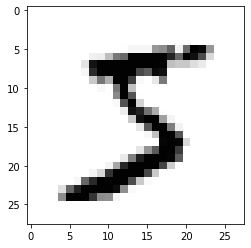

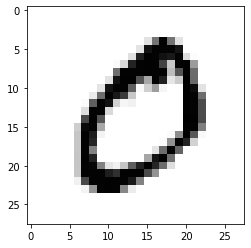

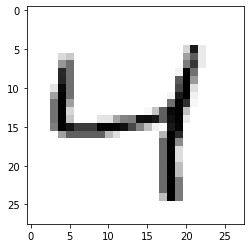

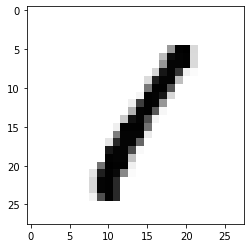

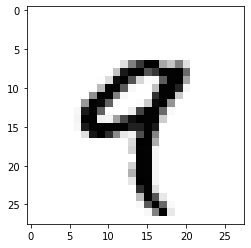

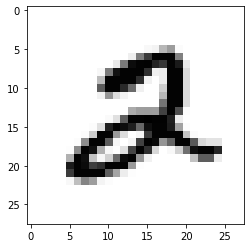

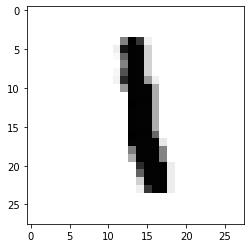

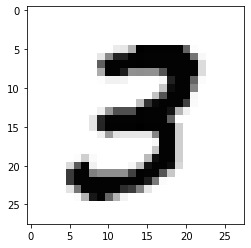

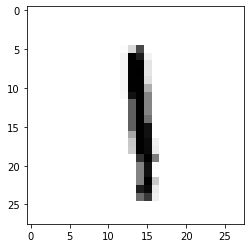

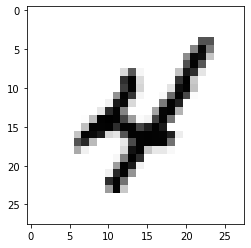

numpy.ndarray

In [2]:
for i in range(10):
    img = np.asfarray(x_train)[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()
type(img)

The grad will hold the gradient from backward propogation if the tensor data is not in the form np array

In [0]:
class Tensors:
    def __init__(self, data, requires_grad=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # This is check whether to run backpropagation or not
        self.requires_grad = requires_grad
        # Tensor gradient
        self._grad = None
        # Operation if tensor was used
        self._grad_fn = None

    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.requires_grad:
            raise Exception('Tensor not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backwards(self, grads=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.requires_grad:
            raise Exception('Tensor not backpropagated')

        self.grad_fn.backward(grad)
        return True

    #Return the Tensor value
    def __str__(self):
        return f'Tensors({str(self.data)})'

    #add the gradients
    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad
    #add the tensor object with other
    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

Operations that neural-network will perform on Tensor object adding two new features


In [0]:
class Oper:
    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

AddOp will be extending from Op Sumation operation with 2 tensors

In [0]:
class AddOp(Oper):
    def forward(self, x: Tensors, y: Tensors):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        requires_grad = x.requires_grad or y.requires_grad
        return Tensors(x.data + y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            # as we have matrix operation one of the parameters can 
            # have partial shape in such scenarion we need to sum
            # gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - 
                                 np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - 
                                        np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, 
                                                keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

MulOp will be extending from Op Multiplication operation with 2 tensors

In [0]:
class MulOp(Oper):
    def forward(self, x: Tensors, y: Tensors):
        self.x = x
        self.y = y
        requires_grad = x.requires_grad or y.requires_grad
        return Tensors(x.data * y.data, requires_grad=requires_grad)

    def backward(self, grad):
        if self.x.requires_grad:
            print(self.x, self.x._grad, grad)
            self.x.add_grad(Tensors(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.requires_grad:
            self.y.add_grad(Tensors(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

Defining the Layer

In [0]:
class Layer:
    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

Sigmoid Activation Function

In [0]:
class Sigmoid:
    def forward(self,x):
        self.x = x   
        return 1/(1+np.exp(-x))

    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

Relu Activation Function Implementation

In [0]:
class Relu(Layer):
    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)

    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

Softmax Activation Function

In [0]:
class SoftmaxCrossentropyWithLogits(Layer):   
    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss

    def backward(self, grad=None):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

Mean Square Error (MSE)

In [0]:
class MSE(Layer):
    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

In [0]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        # Lets iniialise weights
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr

    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b
        
    # This is for Backpropagation
    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using 
        # gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)

        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

The Model consists of Linear Sequential Layer with 784 neurons in the input layer

So, Input(784) => Relu => Hidden(100) => Relu => Hidden(200) => Output(10)

In [0]:
class Model(Layer):
    def __init__(self, lr=0.00001):
        self.lr = lr
        #Defining the layers
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self,x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad

In [15]:
# converts to [0,1] interval
transform = transforms.Compose([transforms.ToTensor(),])
ds = MNIST('./mnist', download=True, transform=transform)
dl = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True)
mn = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0
for e in range(5):
    for i, (image, label) in enumerate(dl):
        x = image.view(2,-1).numpy()

        res = mn(x)
        _loss = loss(res, label.numpy())
        _loss_avg += _loss.mean() # loss mean is calculated
        grad = loss.backward(1)
        mn.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


4.726924922060479
---------
inf
---------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


164.19280936343645
---------
170.23764014738856
---------
158.15323969375288
---------
144.90045095674787
---------
143.31718820919335
---------
140.38025325174763
---------
141.31291752011754
---------
133.45790639441492
---------
132.21741740772097
---------
122.69475299410996
---------
123.62616695830722
---------
126.06509766352727
---------
114.63053913631957
---------
111.38351796251999
---------
104.22947821825764
---------
102.23743642080971
---------
103.54262589884588
---------
102.0173078067015
---------
90.05735082262456
---------
107.8322196460996
---------
95.36223463822344
---------
91.1986350286669
---------
95.83974355846671
---------
93.16385342502217
---------
89.15477938946691
---------
90.77834677555146
---------
86.91787963306788
---------
91.97345399900556
---------
75.43006758195719
---------
73.6805993060507
---------
75.2952704069972
---------
72.6275968356876
---------
74.90823265447789
---------
84.05855052533767
---------
78.30252821966323
---------
77.1429

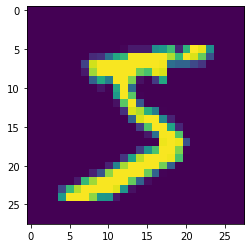

target: 5 predicted: 5


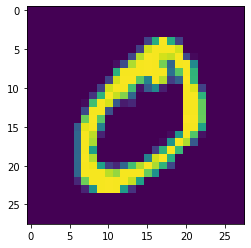

target: 0 predicted: 0


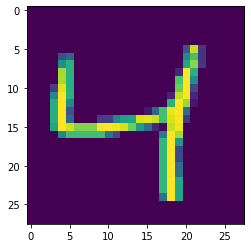

target: 4 predicted: 4


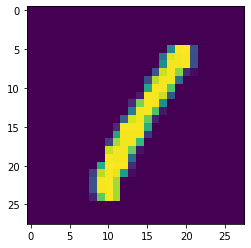

target: 1 predicted: 1


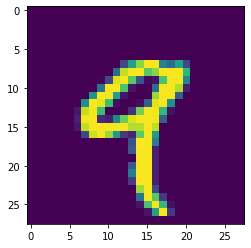

target: 9 predicted: 9


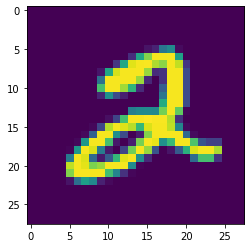

target: 2 predicted: 2


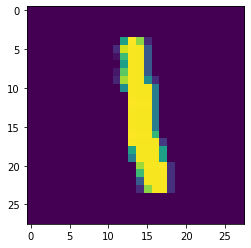

target: 1 predicted: 1


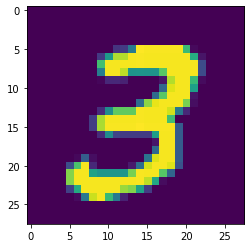

target: 3 predicted: 3


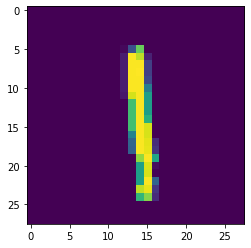

target: 1 predicted: 1


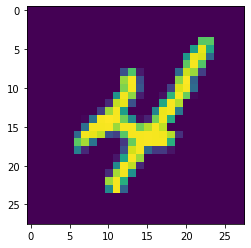

target: 4 predicted: 4


In [17]:
for i in range(10):
    image, target = ds[i]
    plt.imshow(image[0])
    plt.show()
    x = image.view(1,-1).numpy()
    res = mn(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )